In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [103]:
BATCH_SIZE = 32
SEQUENCE_LENGTH = 30
HIDDEN_LAYER_SIZE = 50
LEARNING_RATE = 5e-6

In [104]:
df_all = pd.read_csv("Data/preprocessed_data.csv")


In [105]:
df_all = df_all.dropna()

In [106]:
num_test = len(df_all) // 5


In [107]:
df_data = df_all.drop("Date", axis=1)
# df_train, df_test = train_test_split(df_data, test_size=0.2)
df_train = df_data.iloc[:-num_test, [2]].copy()
df_test = df_data.iloc[-num_test - SEQUENCE_LENGTH:, [2]].copy()
# df_train = df_data.iloc[num_test:, :1].copy()
# df_test = df_data.iloc[:num_test + SEQUENCE_LENGTH:, :1].copy()


In [108]:
sc = StandardScaler()
X_train = sc.fit_transform(df_train)
X_test = sc.transform(df_test)
y_train = df_train[["Bitcoin % Change"]].values
y_test = df_test[["Bitcoin % Change"]].values


In [109]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=SEQUENCE_LENGTH):
        # self.features = features
        # self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(y).float().cuda()
        self.X = torch.tensor(X).float().cuda()

    def __len__(self):
        return self.X.shape[0] - self.sequence_length

    def __getitem__(self, i):
        x = self.X[i:(i + self.sequence_length), :]
        y = self.y[i + self.sequence_length, :]
        return x, y


In [110]:
train_dataset = SequenceDataset(
    X_train,
    y_train,
    sequence_length=SEQUENCE_LENGTH
)

test_dataset = SequenceDataset(
    X_test,
    y_test,
    sequence_length=SEQUENCE_LENGTH
)


In [111]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [112]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer_size = HIDDEN_LAYER_SIZE
        self.lstm = nn.LSTM(input_size=SEQUENCE_LENGTH,
                            hidden_size=self.hidden_layer_size,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True)
        # equivalent to Dense in keras
        self.linear1 = nn.Linear(self.hidden_layer_size, self.hidden_layer_size)
        self.linear2 = nn.Linear(self.hidden_layer_size, 1)

        self.dropout = nn.Dropout(0.5)

        self.hidden_cell = (torch.zeros(2, BATCH_SIZE, self.hidden_layer_size).
                            cuda(),
                            torch.zeros(2, BATCH_SIZE, self.hidden_layer_size).cuda())

    def forward(self, input_seq):
        _, (hn, _) = self.lstm(input_seq.view(
            len(input_seq), 1, -1), self.hidden_cell)
        # lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = self.dropout(self.linear2(hn[-1]))
        # predictions = self.dropout(self.linear2(predictions))
        return predictions


In [113]:
model = LSTM()
model.cuda()
loss_function = nn.MSELoss()
loss_function.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [114]:
def train(model, data_loader, optimizer, criterion):

    epoch_loss = 0

    model.train()

    batch_num = 0

    for X, y in data_loader:

        # print('Training batch', batch_num)

        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(
        ), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

        predictions = model(X)

        # print(predictions.shape, y.shape)

        loss = criterion(predictions, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        batch_num += 1

    return epoch_loss / len(data_loader)


In [115]:
def evaluate(model, data_loader, criterion):

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for X, y in data_loader:

            model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(
            ), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

            predictions = model(X)

            loss = criterion(predictions, y)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)


In [116]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [117]:
N_EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    # print('training...')

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_function)
    valid_loss = evaluate(model, test_loader, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.10f}')
    print(f'\t Val. Loss: {valid_loss:.10f}')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.0018877607
	 Val. Loss: 0.0017848016
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.0019127210
	 Val. Loss: 0.0017856626
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.0019452022
	 Val. Loss: 0.0017864234
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.0019073352
	 Val. Loss: 0.0017871314
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.0019470020
	 Val. Loss: 0.0017869198
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.0018963012
	 Val. Loss: 0.0017857703
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.0019614634
	 Val. Loss: 0.0017867233
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.0019271275
	 Val. Loss: 0.0017854848
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.0019631491
	 Val. Loss: 0.0017849801
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.0018843325
	 Val. Loss: 0.0017851751
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.0018522467
	 Val. Loss: 0.0017843934
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.0019085654
	 Val. Loss: 0.0017831491
Epoch: 13 | Epoc

In [118]:
model.eval()

predictions = []

with torch.no_grad():

    for X, y in test_loader:

        model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

        predictions.append(model(X))


In [119]:
predictions = torch.transpose(torch.vstack(predictions), 0, 1).cpu()

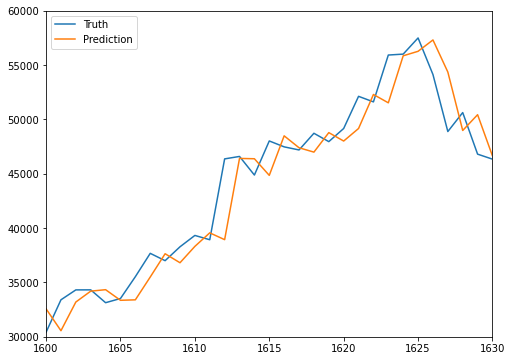

In [126]:
# plt.plot(predictions[0])

df_tmp = df_test.iloc[SEQUENCE_LENGTH:].copy()
df_tmp["Bitcoin % Change (Predicted)"] = predictions[0]
df_tmp["Value (Predicted)"] = (1 + predictions[0]) * df_all["Value"][-len(predictions[0]) - 1: -1].values
df_tmp["Value"] = df_all["Value"][-len(predictions[0]):]
df_tmp

plt.figure(figsize=(8,6))
plt.plot(df_tmp["Value"], label="Truth")
plt.plot(df_tmp["Value (Predicted)"], label="Prediction")

plt.xlim(1600, 1630)
plt.ylim(30000, 60000)
plt.legend()

In [89]:
print(predictions)

tensor([[-2.0434e-03, -9.5541e-03, -5.7687e-03, -1.9178e-03, -6.4519e-03,
         -5.4032e-04,  1.2290e-03, -8.3932e-03,  3.7498e-03, -4.0539e-03,
         -5.2893e-03, -3.9087e-03,  5.0619e-03, -2.3487e-03,  1.9384e-03,
          4.3660e-04, -2.3203e-03,  9.7532e-04, -1.0312e-03,  8.2701e-06,
          3.2534e-03,  1.3540e-03,  5.4123e-03, -1.8417e-03,  7.8665e-04,
         -2.4779e-03, -4.7031e-04, -3.8794e-03, -2.9398e-03, -2.1844e-03,
         -4.3169e-04, -1.4494e-03,  1.8540e-03,  1.3296e-03,  5.0762e-04,
          3.7371e-04,  1.0805e-03,  2.0205e-03, -2.8753e-03,  4.1199e-03,
         -7.0023e-04, -1.4878e-03,  7.3028e-04,  1.0944e-03,  2.7948e-03,
          2.5141e-03,  7.2328e-03,  2.8166e-03, -9.1985e-05,  6.2655e-03,
          3.7222e-03, -1.1045e-03,  1.9465e-03,  3.2154e-03, -4.6863e-03,
          1.0401e-02,  3.2148e-03, -1.2596e-03,  4.3005e-03,  4.4067e-03,
          4.1448e-03,  3.7307e-03,  2.4826e-03, -3.6099e-03,  7.3329e-03,
          5.5313e-03, -7.5126e-03, -2.